# Setup

In [ ]:
%conda install pytorch torchvision torchaudio cudatoolkit = 11.3 - c pytorch
%conda install numpy pandas matplotlib
%pip install opencv-python keyboard Pillow pyautogui wandb

In [11]:
import os
import time
import shutil
import copy
import uuid
import numpy as np
import cv2
import keyboard as kb
from PIL import ImageGrab, ImageFilter
import pyautogui
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import torch
import torchvision
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils, models
import torch.optim as optim
from torch.optim import lr_scheduler

In [15]:
DATA_DIR = 'data'

In [16]:
wandb.login()
wandb.init(project="paper-io-ai", config={
    "epochs": 25,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "step_size": 7,
    "gamma": 0.1
})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eddiezhuang. Use `wandb login --relogin` to force relogin


# Data Collection

In [62]:
# Resets data folder
dirpath = Path('data')
if dirpath.exists():
    shutil.rmtree(dirpath)

os.makedirs(os.path.join('data', 'w'))
os.makedirs(os.path.join('data', 'a'))
os.makedirs(os.path.join('data', 's'))
os.makedirs(os.path.join('data', 'd'))

In [13]:
# Gets coordinates for bbox
kb.wait('enter')

currentMouseX, currentMouseY = pyautogui.position()
print(f'({currentMouseX}, {currentMouseY})')

(1813, 692)


In [17]:
def shoot_screen():
    screenshot = ImageGrab.grab(bbox=(2, 113, 1275, 1027))
    return screenshot

In [66]:
dir = ''

while True:

    if kb.is_pressed('w'):
        dir = 'w'
    elif kb.is_pressed('a'):
        dir = 'a'
    elif kb.is_pressed('s'):
        dir = 's'
    elif kb.is_pressed('d'):
        dir = 'd'
    else:
        dir = ''

    if dir != '':
        screenshot = shoot_screen()
        filename = str(uuid.uuid4()) + '.jpg'
        screenshot.save(f'data/{dir}/{filename}')

    if kb.is_pressed('esc'):
        print('Exiting data collection!')
        break

Exiting data collection!


# Training


## Load Data

In [26]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])
data = datasets.ImageFolder(DATA_DIR, data_transform)
class_names = data.classes
device = torch.device("cuda")
torch.cuda.get_device_name(device)

'NVIDIA GeForce GTX 1650'

In [27]:
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(
    data, [train_size, val_size])
image_datasets = {
    'train': train_data,
    'val': val_data
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

## Visualize Images


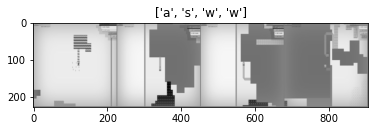

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the Model


In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=wandb.config.epochs):
    wandb.watch(model, log_freq=100)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # load data to GPU
                labels = labels.to(device)

                optimizer.zero_grad()  # clear gradients for this training step

                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            wandb.log({"loss": epoch_loss, "acc": epoch_acc})

            # save the model if it is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [30]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_df = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),
                         lr=wandb.config.learning_rate, momentum=wandb.config.momentum)

exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_ft, step_size=wandb.config.step_size, gamma=wandb.config.gamma)

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, wandb.config.epochs)

Epoch 1/25
----------
train Loss: 1.3255 Acc: 0.4430
val Loss: 0.8397 Acc: 0.6807

Epoch 2/25
----------
train Loss: 0.8212 Acc: 0.6989
val Loss: 0.5469 Acc: 0.8046

Epoch 3/25
----------
train Loss: 0.5921 Acc: 0.7867
val Loss: 0.4097 Acc: 0.8592

Epoch 4/25
----------
train Loss: 0.5184 Acc: 0.8177
val Loss: 0.3052 Acc: 0.8866

Epoch 5/25
----------
train Loss: 0.3965 Acc: 0.8650
val Loss: 0.3537 Acc: 0.8845

Epoch 6/25
----------
train Loss: 0.3758 Acc: 0.8734
val Loss: 0.3483 Acc: 0.8782

Epoch 7/25
----------
train Loss: 0.3206 Acc: 0.9023
val Loss: 0.2822 Acc: 0.9139

Epoch 8/25
----------
train Loss: 0.1793 Acc: 0.9427
val Loss: 0.1947 Acc: 0.9349

Epoch 9/25
----------
train Loss: 0.1262 Acc: 0.9606
val Loss: 0.1881 Acc: 0.9328

Epoch 10/25
----------
train Loss: 0.1029 Acc: 0.9679
val Loss: 0.1731 Acc: 0.9349

Epoch 11/25
----------
train Loss: 0.1003 Acc: 0.9679
val Loss: 0.1614 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.1019 Acc: 0.9737
val Loss: 0.2030 Acc: 0.9328

E

## Visualize Model Predictions


In [32]:
def visualize_model(model, num_images=6):
    """Shows predictions for a few images"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():  # Reduces memory consumption for inference
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Returns the max output

            for j in range(inputs.size()[0]):
                images_so_far += 1

                # // divides and only keeps the integer part
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

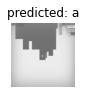

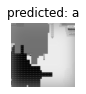

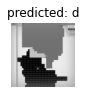

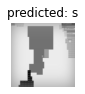

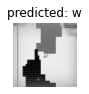

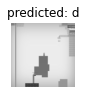

In [33]:
visualize_model(model_ft)

## Save Model


In [34]:
torch.save(model_ft, os.path.join(wandb.run.dir, 'model.pt'))

In [35]:
wandb.finish()

acc,▁▄▄▆▆▆▇▆▇▇▇▇▇█▇██▇█▇▇█▇██▇████▇████▇▇█▇▇
best_acc,▁
loss,█▅▅▄▃▄▂▃▃▃▂▂▂▁▂▁▁▂▁▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂
acc,0.94328
best_acc,0.95168
loss,0.1513


# Inference

## Load the Model


In [36]:
model_file = wandb.restore(
    'model.pt', run_path="eddiezhuang/paper-io-ai/1o0dyh11")

model = torch.load(model_file.name)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Play in Real Time!


In [42]:
def get_pred():
    screenshot = shoot_screen()
    screenshot = data_transform(screenshot).to(device)
    screenshot = screenshot.unsqueeze(0)
    output = model(screenshot)
    print(output)
    _, preds = torch.max(output, 1)
    key = class_names[preds[0]]
    return key

In [43]:
kb.wait('enter')
print('Starting AI playing...')

with torch.no_grad():
    while True:
        key = get_pred()

        kb.send(key)

        if kb.is_pressed('esc'):
            print('Exiting AI playing!')
            break

Starting AI playing...
tensor([[-0.3252, -2.4038,  8.2768, -2.2962, -5.0189]], device='cuda:0')
tensor([[-0.4320, -3.1174,  8.7533, -2.2715, -4.7194]], device='cuda:0')
tensor([[-0.6393, -2.3622,  8.8136, -2.2938, -4.8596]], device='cuda:0')
tensor([[-0.8424, -2.3604,  8.7698, -2.5589, -4.4764]], device='cuda:0')
tensor([[-0.6472, -2.3632,  8.8250, -2.6877, -4.7549]], device='cuda:0')
tensor([[-0.4050, -2.2945,  9.0010, -3.0432, -4.9605]], device='cuda:0')
tensor([[-0.4753, -1.9657,  9.0428, -2.9137, -5.1610]], device='cuda:0')
tensor([[-0.6298, -2.2403,  9.1625, -2.6173, -5.1744]], device='cuda:0')
tensor([[-0.6014, -2.2069,  8.9742, -2.6599, -5.1879]], device='cuda:0')
tensor([[-0.8767, -2.5582,  8.9005, -2.6228, -4.1956]], device='cuda:0')
tensor([[-0.9592, -2.8695,  8.5933, -2.1594, -3.9157]], device='cuda:0')
tensor([[-1.1686, -2.5189,  8.9903, -2.0252, -4.2464]], device='cuda:0')
tensor([[-1.7641, -3.4040,  9.7978, -1.4195, -4.9583]], device='cuda:0')
tensor([[-1.5282, -3.5145,  